# The art of using t-SNE for single-cell transcriptomics
## UMI-based datasets

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
from scipy import sparse

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

# import my feature selection function and other stuff
import rnaseqTools

# data format
from collections import namedtuple
RNAseqData = namedtuple('RNAseqData', 'counts rpkm genes areas clusters clustergroups '
                                      'clusterColors clusterNames clustergroupNames')

## Harris et al., PLoS Bio 2018

The data are taken from:

* `expression.tsv.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE99888
* `analysis_results.tsv` is from https://figshare.com/articles/Transcriptomic_analysis_of_CA1_inhibitory_interneurons/6198656
* `colormap.txt` generated in Matlab as in https://github.com/cortex-lab/Transcriptomics/blob/master/GeneSet.m#L839

     ```
     cm0 = hsv(ceil(49*1.2));                // 49 is the number of clusters
     Yellowness = cm0(:,1)+cm0(:,2);
     Divisor = 1 + max(Yellowness - .7, 0);
     cm = bsxfun(@rdivide, cm0, Divisor);    // then save or copy-paste cm into file```

In [2]:
# counts, genes, cells = rnaseqTools.sparseload('../data/harris-plos/expression.tsv.gz', sep='\t', 
#                                               droplastcolumns=1)

# data = pd.read_csv('../data/harris-plos/analysis_results.tsv', sep='\t')
# clusterNames, clusters = np.unique(data.values[0,1:-1], return_inverse=True)

# data = pd.read_csv('../data/harris-plos/colormap.txt', sep='\s+', header=None)
# clusterColors = data.values

# # Note: the color order needs to be reversed to match the publication
# clusterColors = clusterColors[::-1]

# # Taken from Figure 1 - we need cluster order to get correct color order
# clusterOrder = ['Sst.No', 'Sst.Npy.C', 'Sst.Npy.Z', 'Sst.Npy.S', 'Sst.Npy.M',
#                 'Sst.Pnoc.Calb1.I', 'Sst.Pnoc.Calb1.P', 'Sst.Pnoc.P', 'Sst.Erbb4.R',
#                 'Sst.Erbb4.C', 'Sst.Erbb4.T', 'Pvalb.Tac1.N', 'Pvalb.Tac1.Ss',
#                 'Pvalb.Tac1.Sy', 'Pvalb.Tac1.A', 'Pvalb.C1ql1.P', 'Pvalb.C1ql1.C',
#                 'Pvalb.C1ql1.N', 'Cacna2d1.Lhx6.R', 'Cacna2d1.Lhx6.V', 'Cacna2d1.Ndnf.N',
#                 'Cacna2d1.Ndnf.R', 'Cacna2d1.Ndnf.C', 'Calb2.Cry', 'Sst.Cry', 'Ntng1.S',
#                 'Ntng1.R', 'Ntng1.C', 'Cck.Sema', 'Cck.Lmo1.N', 'Cck.Calca', 'Cck.Lmo1.Vip.F',
#                 'Cck.Lmo1.Vip.C', 'Cck.Lmo1.Vip.T', 'Cck.Ly', 'Cck.Cxcl14.Calb1.Tn',
#                 'Cck.Cxcl14.Calb1.I', 'Cck.Cxcl14.S', 'Cck.Cxcl14.Calb1.K',
#                 'Cck.Cxcl14.Calb1.Ta', 'Cck.Cxcl14.V', 'Vip.Crh.P', 'Vip.Crh.C1', 'Calb2.Vip.G',
#                 'Calb2.Vip.I', 'Calb2.Vip.Nos1', 'Calb2.Cntnap5a.R', 'Calb2.Cntnap5a.V',
#                 'Calb2.Cntnap5a.I']

# reorder = np.zeros(clusterNames.size) * np.nan
# for i,c in enumerate(clusterNames):
#     for j,k in enumerate(clusterOrder):
#         if c[:len(k)]==k:
#             reorder[i] = j
#             break
# clusterColors = clusterColors[reorder.astype(int)]

# harris = RNAseqData(counts=counts, genes=genes, clusters=clusters, 
#                     clusterColors=clusterColors, clusterNames=clusterNames,
#                     rpkm=None, areas=None, clustergroups=None, clustergroupNames=None)

# pickle.dump(harris, open('../data/harris-plos/harris.pickle', "wb"))

In [11]:
harris = pickle.load(open('../data/harris-plos/harris.pickle', "rb"))
print(harris.counts.shape)

(3663, 27998)


Chosen offset: 0.52


/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


<IPython.core.display.Javascript object>


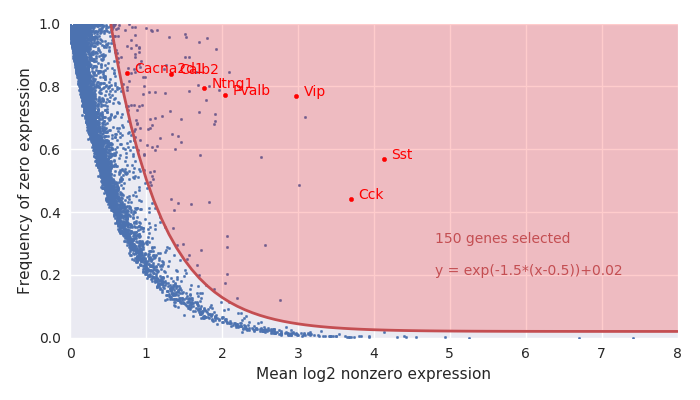

In [12]:
# Feature selection

importantGenes = rnaseqTools.geneSelection(harris.counts, decay=1.5, n=150,
                               genes = harris.genes,
                               markers=['Sst', 'Pvalb', 'Cacna2d1', 'Calb2', 'Ntng1', 'Cck', 'Vip'])

# Library size normalization and log(x+1) transform

librarySizes = np.array(np.sum(harris.counts, axis=1))
X = np.log2(harris.counts[:, importantGenes] / librarySizes * 1e+6 + 1)  
X = np.array(X)

# PCA

X = X - X.mean(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

<IPython.core.display.Javascript object>


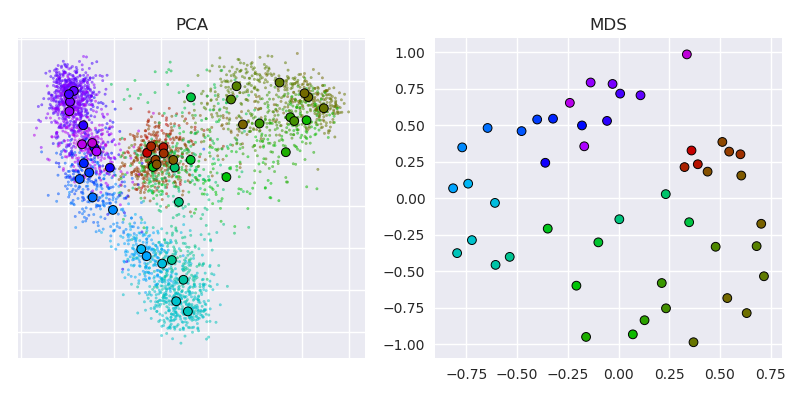

In [5]:
# PCA and MDS

plt.figure(figsize=(8,4))
plt.subplot(121)
cryabCluster = np.where(harris.clusterNames=='Sst.Cryab')[0]
rnaseqTools.scatterPlot(X[:,:2], harris, size=None, showlabels=False, 
                        hideclustermeans=cryabCluster, title='PCA')

K = harris.clusterNames.size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.mean(X[harris.clusters==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)
B[cryabCluster,:] = np.nan

plt.subplot(122)
plt.scatter(B[:,0], B[:,1], color=harris.clusterColors,
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS')
plt.tight_layout()

<IPython.core.display.Javascript object>


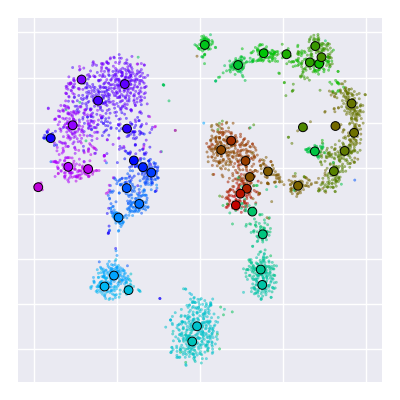

In [13]:
# t-SNE

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Z_harris_default = fast_tsne(X, perplexity=50, seed=42)
Z_harris = fast_tsne(X, perplexity=50, initialization=PCAinit)

cryabCluster = np.where(harris.clusterNames=='Sst.Cryab')[0]
rnaseqTools.scatterPlot(Z_harris, harris, showlabels=False, hideclustermeans=cryabCluster)

<IPython.core.display.Javascript object>


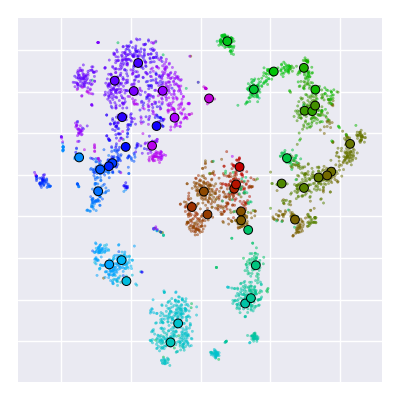

In [7]:
# What happens if we use standardization before PCA

X = np.log2(harris.counts[:, importantGenes] / librarySizes * 1e+6 + 1)  
X = np.array(X)
X = X - X.mean(axis=0)
X = X / X.std(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]
X = X / np.max(np.abs(X))

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Z = fast_tsne(X, perplexity=50, initialization=PCAinit)

cryabCluster = np.where(harris.clusterNames=='Sst.Cryab')[0]
rnaseqTools.scatterPlot(Z, harris, showlabels=False, hideclustermeans=cryabCluster)

## Shekhar et al., Cell 2016

The data are taken from:
* `GSE81904_BipolarUMICounts_Cell2016.txt.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81904
* `clust_retinal_bipolar` is from https://hemberg-lab.github.io/scRNA.seq.datasets/mouse/retina/

In [8]:
# filename = '../data/shekhar-cell/GSE81904_BipolarUMICounts_Cell2016.txt.gz'
# counts, genes, cells = rnaseqTools.sparseload(filename, sep='\t')

# clusterData = pd.read_csv('../data/shekhar-cell/clust_retinal_bipolar.txt', sep='\t')

# clusterNames, clusters = np.unique(clusterData.values[:,1], return_inverse=True)
# clusterNames[clusterNames=='BC5A (Cone Bipolar cell 5A)'] = 'BC5A'
# clusterNames[clusterNames=='BC7 (Cone Bipolar cell 7)'] = 'BC7'
# clusterNames[clusterNames=='BC8/9 (mixture of BC8 and BC9)'] = 'BC8/9'
# clusterNames[clusterNames=='AC (Amacrine cell)'] = 'Amacrine cells'
# clusterNames[clusterNames=='Cone Photoreceptors'] = 'Cones'
# clusterNames[clusterNames=='Rod Photoreceptors'] = 'Rods'
# clusterNames[clusterNames=='MG (Mueller Glia)'] = 'Mueller Glia'
# clusterNames[clusterNames=='RBC (Rod Bipolar cell)'] = 'RBC'

# # Taken from Figure 1
# clusterColors = ['#39dcd5', '#ffa302', '#fc8203', '#fd6301',
#                  '#fa4101', '#fe1e00', '#fc0005', '#acd8e5',
#                  '#92b6e6', '#566be9', '#759ae9', '#3747f4',
#                  '#4458f2', '#0004f3', '#fafc0a', '#8d8d8d',
#                  '#1afbfe', '#00ff00', '#fefd1a']
# clusterColors = np.array(clusterColors)

# goodcells = clusterData.values[:,0]
# cell2cluster = dict(zip(goodcells, clusters))
# ind = np.isin(cells, goodcells)
# cells = cells[ind]
# counts = counts[ind,:]
# clusters = np.array([cell2cluster[c] for c in cells])

# shekhar = RNAseqData(counts=counts, genes=genes, clusters=clusters, 
#                      clusterColors=clusterColors, clusterNames=clusterNames,
#                      rpkm=None, areas=None, clustergroups=None, clustergroupNames=None)

# pickle.dump(shekhar, open('../data/shekhar-cell/shekhar.pickle', "wb"), protocol=4)

In [2]:
shekhar = pickle.load(open('../data/shekhar-cell/shekhar.pickle', "rb"))
print(shekhar.counts.shape)

(27499, 24904)


Chosen offset: 0.21


/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


<IPython.core.display.Javascript object>


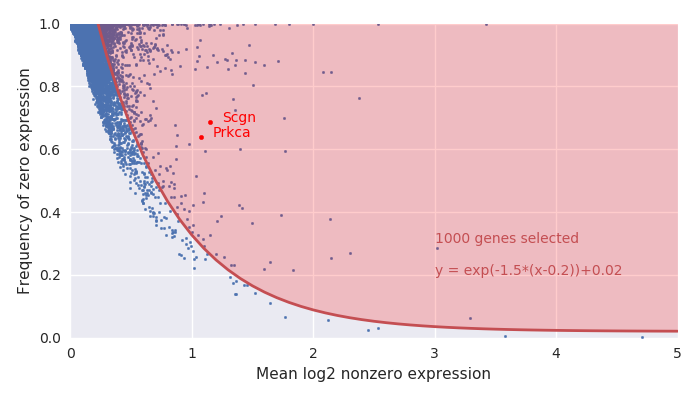

In [3]:
# Feature selection

importantGenes = rnaseqTools.geneSelection(shekhar.counts, decay=1.5, n=1000,
                               genes = shekhar.genes, markers=['Prkca', 'Scgn'])

# Library size normalization and log(x+1) transform

librarySizes = np.array(np.sum(shekhar.counts, axis=1))
X = np.log2(shekhar.counts[:, importantGenes] / librarySizes * 1e+6 + 1)  
X = np.array(X)

# PCA (after standardizing)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

<IPython.core.display.Javascript object>


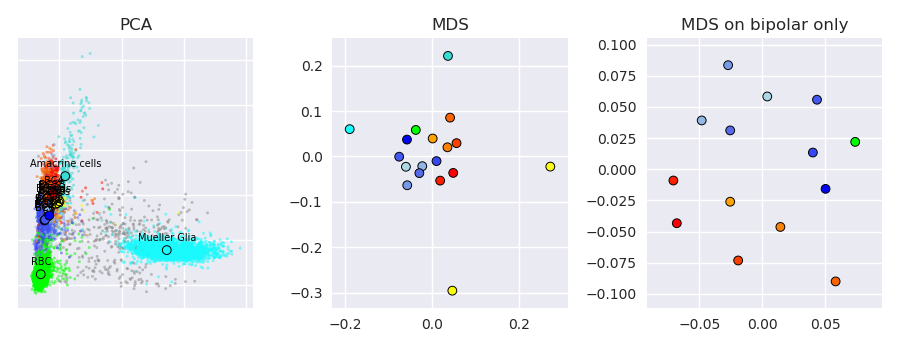

In [11]:
# PCA and MDS

plt.figure(figsize=(9,3.5))
plt.subplot(131)
doubletClusterNum = np.where(shekhar.clusterNames == 'Doublets/Contaminants')[0]
rnaseqTools.scatterPlot(X[:,:2], shekhar, size=None, hideclustermeans=doubletClusterNum, 
                        title='PCA', labels_dy=.01)

K = shekhar.clusterNames.size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.median(X[shekhar.clusters==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)
B[doubletClusterNum, :] = np.nan

plt.subplot(132)
plt.scatter(B[:,0], B[:,1], color=shekhar.clusterColors,
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS')
plt.tight_layout()

bcs = [i for i,c in enumerate(shekhar.clusterNames) if c[:2]=='BC' or c[:2]=='RB']
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans[bcs,:])
plt.subplot(133)
plt.scatter(B[:,0], B[:,1], color=shekhar.clusterColors[bcs],
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS on bipolar only')
plt.tight_layout()

<IPython.core.display.Javascript object>


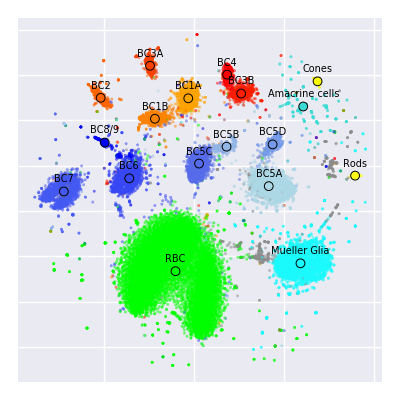

In [9]:
PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Zsigma = fast_tsne(X, K=1000, sigma=.05, initialization=PCAinit) 

doubletCluster = np.where(shekhar.clusterNames == 'Doublets/Contaminants')[0]
rnaseqTools.scatterPlot(Zsigma, shekhar, hideclustermeans=doubletCluster)

<IPython.core.display.Javascript object>


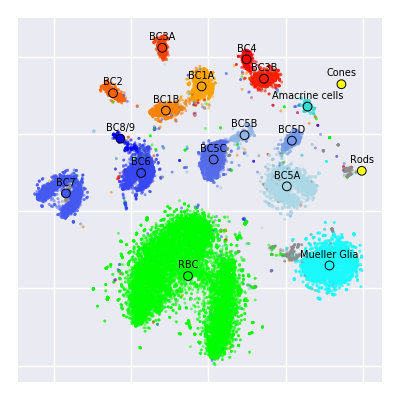

In [10]:
Z_shekhar_default = fast_tsne(X, perplexity=50, seed=42)

Z_shekhar = fast_tsne(X, perplexity=50, initialization=Zsigma, early_exag_coeff=1.2, stop_early_exag_iter=1000)
rnaseqTools.scatterPlot(Z_shekhar, shekhar, hideclustermeans=doubletCluster)

/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


CPU times: user 3min 19s, sys: 572 ms, total: 3min 19s
Wall time: 50.4 s


<IPython.core.display.Javascript object>


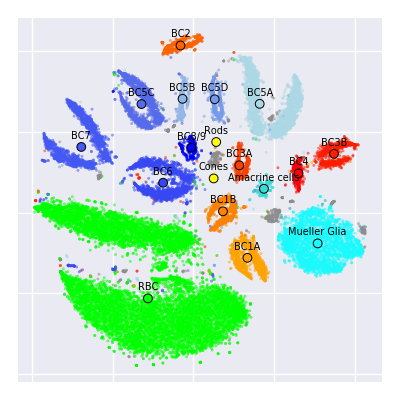

In [14]:
# USING 10k GENES - this is close to the pre-processing pipeline in the paper
# Produces much stronger batch effect

imp10k = rnaseqTools.geneSelection(shekhar.counts, decay=1.5, n=10000, plot=False)

librarySizes = np.array(np.sum(shekhar.counts, axis=1))
X = np.log2(shekhar.counts[:, imp10k] / librarySizes * 1e+6 + 1)  
X = np.array(X)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)
%time U,s,V = scipy.sparse.linalg.svds(X, k=50)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]]

PCAinit = X[:,:2]/np.std(X[:,0])*.0001
Z = fast_tsne(X, perplexity=50, initialization=PCAinit)
rnaseqTools.scatterPlot(Z, shekhar, hideclustermeans=doubletCluster)

## Macosko et al. 2015

The data are taken from:

* `GSE63472_P14Retina_merged_digital_expression.txt.gz` is from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63472
* `retina_clusteridentities.txt` is from http://mccarrolllab.org/wp-content/uploads/2015/05/retina_clusteridentities.txt

In [15]:
# filename = '../data/makosco-cell/GSE63472_P14Retina_merged_digital_expression.txt.gz'
# counts, genes, cells = rnaseqTools.sparseload(filename, sep='\t')
# genes = np.array([g[0]+g[1:].lower() for g in genes])

# data = pd.read_csv('../data/makosco-cell/retina_clusteridentities.txt', sep='\t', header=None)
# cell2cluster = dict(data.values)
# goodcells = np.array(data.values[:,0])

# ind = np.isin(cells, goodcells)
# cells = cells[ind]
# counts = counts[ind,:]

# clusterNames = ['Horizontal cells', 'Ganglion cells']
# for c in range(3,24):
#     clusterNames.append(str(c))
# clusterNames.extend(('Rods', 'Cones'))
# for c in range(26,34):
#     clusterNames.append(str(c))
# clusterNames.extend(('Mueller glia', 'Astrocytes', 'Fibroblasts', 
#                      'Endothelium', 'Pericytes', 'Microglia'))
# clusterNames = np.array(clusterNames)

# clusterColors = ['#b33b19', '#c38a1f'] + ['#9ac222']*21 + ['#538cba']*2 + \
#                 ['#2000d7']*8 + ['#8b006b']*6
# clusterColors = np.array(clusterColors)

# macosko = RNAseqData(counts = counts, genes = genes,
#                      clusters = np.array([cell2cluster[c] for c in cells]) - 1,
#                      clusterColors = clusterColors,
#                      clusterNames = clusterNames,
#                      clustergroups = None, clustergroupNames = None,
#                      rpkm = None, areas=None)

# pickle.dump(macosko, open('../data/makosco-cell/macosko.pickle', "wb"))

In [14]:
macosko = pickle.load(open('../data/makosco-cell/macosko.pickle', "rb"))
print(macosko.counts.shape)

(44808, 24658)


Chosen offset: 0.19


/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


<IPython.core.display.Javascript object>


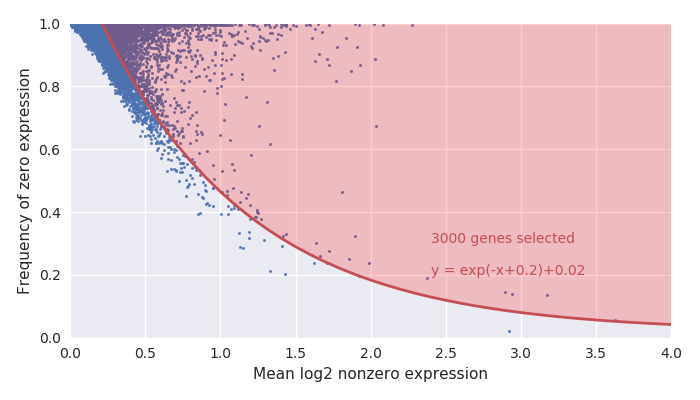

In [15]:
importantGenes = rnaseqTools.geneSelection(macosko.counts, n=3000)

librarySizes = np.array(np.sum(macosko.counts, axis=1))
X = np.log2(macosko.counts[:, importantGenes] / librarySizes * 1e+6 + 1)  
X = np.array(X)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)
U,s,V = np.linalg.svd(X, full_matrices=False)
U[:, np.sum(V,axis=1)<0] *= -1
X = np.dot(U, np.diag(s))
X = X[:, np.argsort(s)[::-1]][:,:50]

X = X / np.max(np.abs(X))

<IPython.core.display.Javascript object>


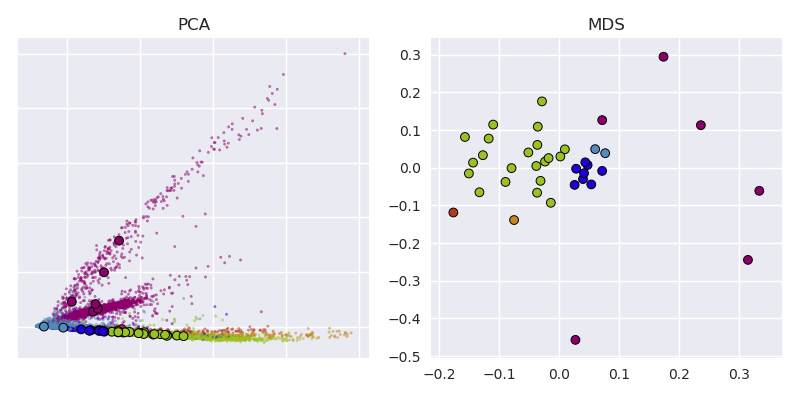

In [18]:
# PCA and MDS

plt.figure(figsize=(8,4))
plt.subplot(121)
rnaseqTools.scatterPlot(X[:,:2], macosko, size=None, showlabels=False)
plt.title('PCA')

K = macosko.clusterNames.size
Zmeans = np.zeros((K, 50))
for c in range(K):
    Zmeans[c,:] = np.mean(X[macosko.clusters==c, :], axis=0)

from sklearn.manifold import MDS
embedding = MDS(n_components=2, n_init=500, random_state=42)
B = embedding.fit_transform(Zmeans)

plt.subplot(122)
plt.scatter(B[:,0], B[:,1], color=macosko.clusterColors,
            s=40, edgecolor='k', linewidth=.7);
plt.title('MDS')
plt.tight_layout()

<IPython.core.display.Javascript object>


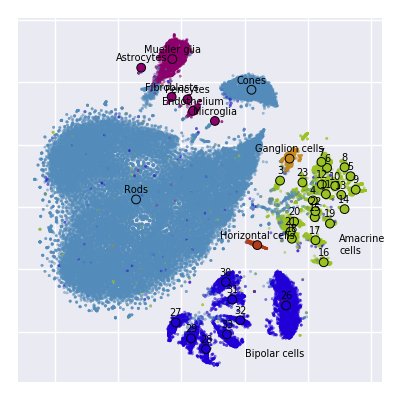

In [16]:
Z_macosko_default = fast_tsne(X, perplexity=50, seed=42, learning_rate=1000)

PCAinit = X[:,:2] / np.std(X[:,0]) * .0001
Z_macosko = fast_tsne(X, perplexity_list=[50,500], initialization=PCAinit, learning_rate=1000, load_affinities='load')

rnaseqTools.scatterPlot(Z_macosko, macosko)
plt.text(50, -15, 'Amacrine\ncells', color='k', fontsize=7) 
plt.text(20, -48, 'Bipolar cells', color='k', fontsize=7);

## Combined figure

<IPython.core.display.Javascript object>


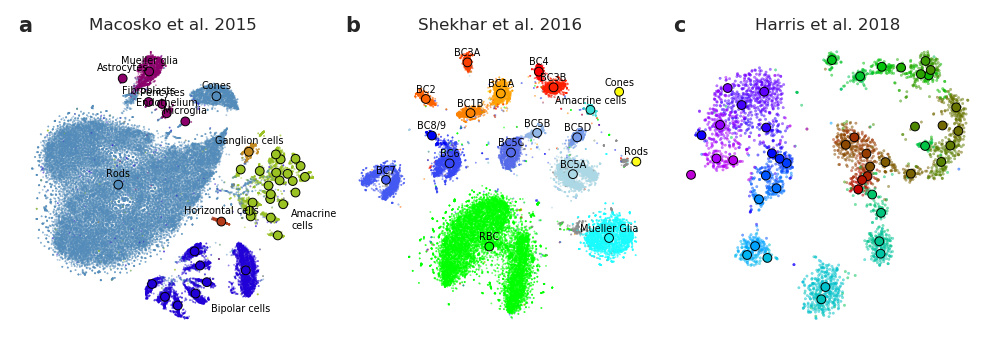

In [17]:
sns.set_style('white')

plt.figure(figsize=(10,3.5))
plt.subplot(131)
numberedClusters = np.array([i for i,c in enumerate(macosko.clusterNames) if len(c)<=2])
rnaseqTools.scatterPlot(Z_macosko, macosko, title='Macosko et al. 2015', size=None, 
                        s=1, labels_dy=3, alpha=.4, hideclusterlabels=numberedClusters)
plt.text(50, -15, 'Amacrine\ncells', color='k', fontsize=7) 
plt.text(20, -48, 'Bipolar cells', color='k', fontsize=7) 
plt.subplot(132)
doubletCluster = np.where(shekhar.clusterNames == 'Doublets/Contaminants')[0]
rnaseqTools.scatterPlot(Z_shekhar, shekhar, title='Shekhar et al. 2016', size=None,
                        hideclustermeans=doubletCluster, s=1)
plt.subplot(133)
cryabCluster = np.where(harris.clusterNames=='Sst.Cryab')[0]
rnaseqTools.scatterPlot(Z_harris, harris, title='Harris et al. 2018', size=None, 
                        showlabels=False, hideclustermeans=cryabCluster, s=3, alpha=.5)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.text(0, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(0, 1.02, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.savefig('figures/umis.png')
plt.savefig('figures/umis.pdf', dpi=600)

sns.set()

<IPython.core.display.Javascript object>


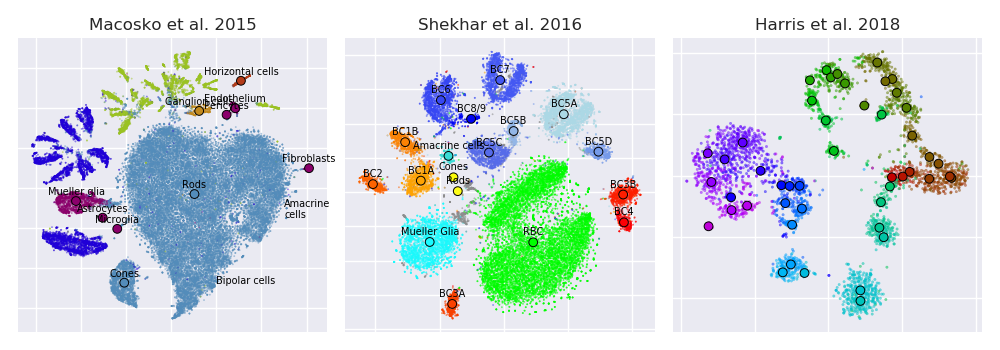

In [21]:
plt.figure(figsize=(10,3.5))
plt.subplot(131)
numberedClusters = np.array([i for i,c in enumerate(macosko.clusterNames) if len(c)<=2])
rnaseqTools.scatterPlot(Z_macosko_default, macosko, title='Macosko et al. 2015', size=None, 
                        s=1, labels_dy=3, alpha=.4, hideclustermeans=numberedClusters)
plt.text(50, -15, 'Amacrine\ncells', color='k', fontsize=7) 
plt.text(20, -48, 'Bipolar cells', color='k', fontsize=7) 
plt.subplot(132)
doubletCluster = np.where(shekhar.clusterNames == 'Doublets/Contaminants')[0]
rnaseqTools.scatterPlot(Z_shekhar_default, shekhar, title='Shekhar et al. 2016', size=None,
                        hideclustermeans=doubletCluster, s=1)
plt.subplot(133)
cryabCluster = np.where(harris.clusterNames=='Sst.Cryab')[0]
rnaseqTools.scatterPlot(Z_harris_default, harris, title='Harris et al. 2018', size=None, 
                        showlabels=False, hideclustermeans=cryabCluster, s=3, alpha=.5)

plt.tight_layout()
plt.savefig('figures/umis-default.png')

## Shekhar/Macosko correspondence

In [22]:
importantGenes = rnaseqTools.geneSelection(shekhar.counts, n=1000, decay=1.5, plot=False)
bipolar = (macosko.clusters>=26-1) & (macosko.clusters<=32-1)

pos = np.zeros((macosko.counts.shape[0], 2))
pos[bipolar,:] = rnaseqTools.map_to_tsne(shekhar.counts[:,importantGenes], shekhar.genes[importantGenes],
                                         macosko.counts[bipolar,:], macosko.genes, Z_shekhar)

/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:38: RuntimeWarning: invalid value encountered in true_divide
  meanExpr = np.squeeze(np.array(A.mean(axis=0))) / (1-zeroRate)
/home/localadmin/Dropbox (Machens Lab)/Link to rnaseq/rna-seq-tsne/rnaseqTools.py:51: RuntimeWarning: invalid value encountered in greater
  selected = zeroRate > np.exp(-decay*(meanExpr - xoffset)) + yoffset


Using a common set of 936 genes.
Processing in batches...... done


<IPython.core.display.Javascript object>


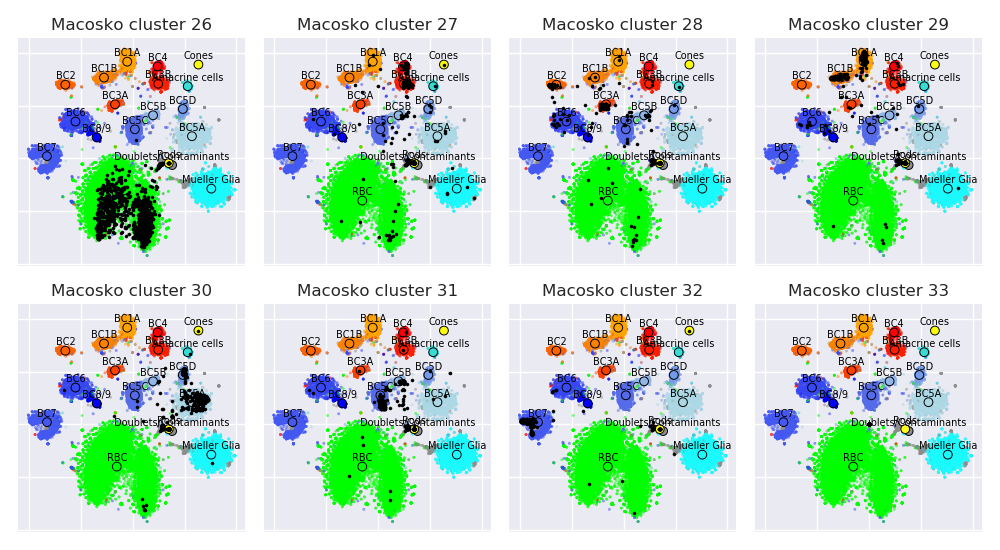

In [23]:
plt.figure(figsize=(10,5.5))
for cl in range(26,33+1):
    plt.subplot(2,4,cl-25)
    rnaseqTools.scatterPlot(Z_shekhar, shekhar, size=None, title='Macosko cluster ' + str(cl))
    plt.scatter(pos[macosko.clusters==cl-1,0], pos[macosko.clusters==cl-1,1], color='k', s=5)
plt.tight_layout()

# plt.savefig('figures/macosko-to-shekhar.png')